### Cell Type proportions as a function of distance

**Date**: 2020-09-10<br>
**Author**: Alma Andersson<br>
**Description**:<br>

Similar to `vein-analysis-ipynb` but using cell type proportions mapped by `stereoscope` rather than normalized expression values, in order to asses how cell type proportions varies as a function of the distance to veins.



## Setup

Load data the necessary packages and data for the analysis, also specify certain constants which will be used throughout the analysis.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import anndata as ad

import re
import datetime

import os
import os.path as osp
from os import listdir

import matplotlib.pyplot as plt


from functools import reduce


from hepaquery import utils as ut

import hepaquery.visual as viz

## Set global parameters and paths

In [12]:
SAVE_RESULTS = True

TAG = re.sub(":| |-|\\.|","",str(datetime.datetime.today()))
TAG = TAG + "-analysis"

REPO_DIR = osp.dirname(osp.abspath(os.getcwd()))
DATA_DIR = osp.join(REPO_DIR,"data/h5ad-cca")
PROP_DIR = osp.join(REPO_DIR,"res/stereoscope-res/")


RESULTS_DIR = osp.join(REPO_DIR,"res",TAG)

if not osp.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

SCALE_FACTOR = 0.26


PTHS = list(filter(lambda x: x.split(".")[-1] == "h5ad",os.listdir(DATA_DIR)))
PTHS = {p.split(".")[0]:osp.join(DATA_DIR,p) for p in PTHS }

## Load data

In [13]:
#exclude = ["CN65-C1","CN65-C2","CN16-D1", "CN16-E1"]  # uncomment if you want to exclude
exclude = []
data_set = {n:ad.read_h5ad(p) for n,p in PTHS.items()}

for ex in exclude:
    data_set.pop(ex)

data_set

{'CN65-E1': AnnData object with n_obs × n_vars = 590 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-C1': AnnData object with n_obs × n_vars = 647 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN16-E1': AnnData object with n_obs × n_vars = 1348 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-E2': AnnData object with n_obs × n_vars = 650 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-D1': AnnData object with n_obs × n_vars = 663 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 's

In [14]:
import glob

prop_files = glob.glob(osp.join(PROP_DIR,"*/W*tsv"))

read_file = lambda f: pd.read_csv(f, sep = '\t', header = 0,index_col=0)
props = {osp.basename(osp.dirname(p)).replace("_","-"):read_file(p) for p in prop_files}




### Merge vein proximity information and proportions

In [15]:
for k in data_set.keys():
    if k in props.keys():
        inter = data_set[k].obs.index.intersection(props[k].index)

        _adata = data_set[k][inter,:]
        _prop = props[k].loc[inter,:]
        _prop /= _prop.max(axis = 0)
        _adata.obsm["proportions"] = _prop

        data_set[k] = _adata
    else:
        data_set[k] = None

In [16]:
data_set = {k:v for k,v in data_set.items() if isinstance(v,ad.AnnData)}

## Analysis : Proportion by distance

Model cell type proportion as a function of the distance to the nearest gene. We use loess regression to get an approximation of the curve that describe the trends in the data. Envelopes represent 1 standard error.

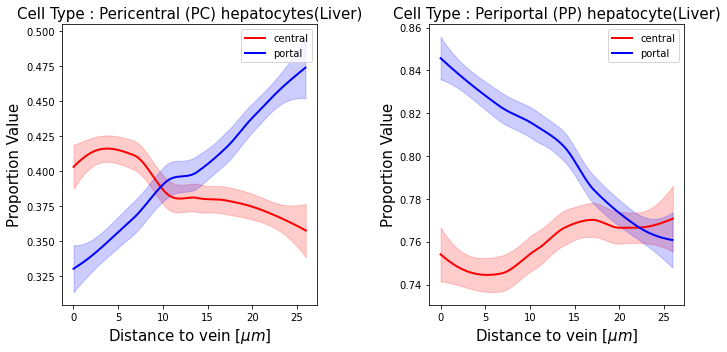

In [17]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 100

# which genes to be assessed
cell_types = dict(central = "Pericentral (PC) hepatocytes(Liver)",portal = "Periportal (PP) hepatocyte(Liver)")

# distance values to use

colormap = dict(central = {"envelope":"red",
                           "fitted":"red",
                           "background":"red"},
               portal = {"envelope":"blue",
                         "fitted":"blue",
                         "background":"blue"},
               )

fig,ax = viz.get_figure(len(cell_types),
                       n_cols = 5,
                       side_size = 5,
                      )
fig.set_facecolor("white")

# iterate over each type
for k,(cell_type,name) in enumerate(cell_types.items()):
    
    for vt in ["central","portal"]:

        xs = np.array([])
        ys = np.array([])

        for data in data_set.values():
            if name not in data.obsm["proportions"].columns:
                print("can't find {}".format(name))
                continue

            min_dist = data.obsm["vein_distances"]["dist_type_" + vt].values
            xs = np.append(xs,min_dist)
            ys = np.append(ys,data.obsm["proportions"][name].values)
        
        smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
        
        viz.plot_expression_by_distance(ax[k],
                                       data = smoothed,
                                       curve_label = vt,
                                       color_scheme = colormap[vt],
                                       include_background = False,
                                       feature = name,
                                        distance_scale_factor = SCALE_FACTOR,
                                        feature_type = "Cell Type",
                                       )
        
        ax[k].set_ylabel("Proportion Value")
        ax[k].set_xlabel("Distance to vein [" + r"$\mu m$" + "]")
        ax[k].legend()

fig.tight_layout()

if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,
                         "proportion-by-distance.svg"),
                facecolor = "white",
                dpi = 300)
    
plt.show()